# XSS\-Detection 

Steps:
1. word2vec
2. some data processing 
3. MLP
4. More can be done (LSTM or something)

In [1]:
!pip install gensim
# CPU version 
!pip install tensorflow
!pip install keras

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


You should consider upgrading via the 'D:\Files\Projects\PycharmProjects\Data-Mining-Experiments\XSS-Detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


You should consider upgrading via the 'D:\Files\Projects\PycharmProjects\Data-Mining-Experiments\XSS-Detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


You should consider upgrading via the 'D:\Files\Projects\PycharmProjects\Data-Mining-Experiments\XSS-Detection\venv\Scripts\python.exe -m pip install --upgrade pip' command.


## 1\. word2vec 

Segmentation has to be done before creating word vectors\.

Principles are given below:
- `"xss"` or `'xss'`
- URLs including `HTTP` or `HTTPS`
- labels (like `<script>`)
- beginning (like `<h1`)
- params (like `topic=`)
- functions (like `alert(`)
- strings consisting of digits and characters (need to be normalized)

In [2]:
import csv, pickle, time, os
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from gensim.models.word2vec import Word2Vec
import nltk
import re
from urllib.parse import unquote

In [3]:
# utils 
def GeneSeg(payload):
    # normalization 
    # digits -> '0'
    payload=payload.lower()
    payload=unquote(unquote(payload))
    payload,num=re.subn(r'\d+',"0",payload)
    # URLs -> 'http://u'
    payload,num=re.subn(r'(http|https)://[a-zA-Z0-9\.@&/#!#\?]+', "http://u", payload)
    # segmentation 
    r = '''
        (?x)[\w\.]+?\(
        |\)
        |"\w+?"
        |'\w+?'
        |http://\w
        |</\w+>
        |<\w+>
        |<\w+
        |\w+=
        |>
        |[\w\.]+
    '''
    return nltk.regexp_tokenize(payload, r)

In [4]:
learning_rate = 0.1
vocabulary_size = 3000
batch_size = 128
embedding_size = 128
num_skips = 4
skip_window = 5
num_sampled = 64
num_iter = 5
plot_only = 100

log_dir = "./word2vec/word2vec.log"
plt_dir = "./word2vec/word2vec.png"
vec_dir = "./word2vec/word2vec.pickle"
data_dir = "./data/"

d:\Files\Projects\PycharmProjects\Data-Mining-Experiments\XSS-Detection\venv\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


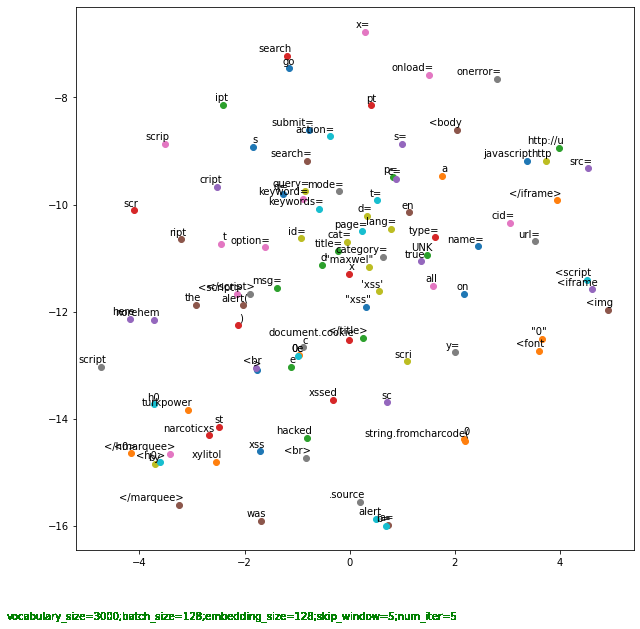

Job completed in: 12.241477489471436
Save word vectors to: ./word2vec/word2vec.pickle


<Figure size 432x288 with 0 Axes>

In [6]:
start=time.time()
words=list()
datas=list()


with open(os.path.join(data_dir, "xssed.csv"), "r", encoding="utf-8") as f:
    reader = csv.DictReader(f,fieldnames=["payload"])
    for row in reader:
        payload = row["payload"]
        word = GeneSeg(payload)
        datas.append(word)
        words += word
f.close()


# build dataset 
def build_dataset(datas,words):
    count = [["UNK",-1]]
    counter = Counter(words)
    count.extend(counter.most_common(vocabulary_size-1))
    vocabulary = [c[0] for c in count]
    data_set = []
    for data in datas:
        d_set = []
        for word in data:
            if word in vocabulary:
                d_set.append(word)
            else:
                d_set.append("UNK")
                count[0][1] += 1
        data_set.append(d_set)
    return data_set
data_set = build_dataset(datas,words)

# do pay attention to params 
model = Word2Vec(data_set, vector_size=embedding_size, window=skip_window, negative=num_sampled, epochs=num_iter)
embeddings = model.wv


def plot_with_labels(low_dim_embs, labels, filename=plt_dir):
    plt.figure(figsize=(10,10))
    for i,label in enumerate(labels):
        x,y = low_dim_embs[i,:]
        plt.scatter(x,y)
        plt.annotate(label,xy=(x, y),xytext=(5, 2),
                     textcoords = "offset points",
                     ha = "right",
                     va = "bottom")
        f_text = "vocabulary_size=%d;batch_size=%d;embedding_size=%d;skip_window=%d;num_iter=%d"%(
            vocabulary_size,batch_size,embedding_size,skip_window,num_iter
        )
        plt.figtext(0.03,0.03,f_text,color="green",fontsize=10)
    plt.show()
    plt.savefig(filename)


# a warning unavoidable
tsne=TSNE(perplexity=30,n_components=2,init="pca",n_iter=5000, learning_rate=200.0)
# `index2word` has been replaced by `index_to_key`
plot_words = embeddings.index_to_key[:plot_only]
plot_embeddings = []

for word in plot_words:
    plot_embeddings.append(embeddings[word])
low_dim_embs=tsne.fit_transform(plot_embeddings)
plot_with_labels(low_dim_embs,plot_words)


def save(embeddings):
    dictionary = dict([(embeddings.index_to_key[i],i)for i in range(len(embeddings.index_to_key))])
    reverse_dictionary = dict(zip(dictionary.values(),dictionary.keys()))
    word2vec = {"dictionary": dictionary,"embeddings": embeddings,"reverse_dictionary": reverse_dictionary}
    with open(vec_dir, "wb") as f:
        pickle.dump(word2vec,f)
    f.close()

save(embeddings)
end=time.time()
print("Job completed in: {}\nSaving word vectors to: {}".format(end-start, vec_dir))

## 2\. Data Processing (preparations for MLP)

In [8]:
import csv,pickle,random,json
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


In [9]:
vec_dir = "./word2vec/word2vec.pickle"
pre_datas_train = "./pre/pre_data_train.csv"
pre_datas_test = "./pre/pre_data_test.csv"
process_datas_dir = "./pre/process_data.pickle"

In [13]:
def build_dataset(batch_size):
    with open(vec_dir, "rb") as f:
        word2vec = pickle.load(f)
    f.close()
    embeddings = word2vec["embeddings"]
    reverse_dictionary = word2vec["reverse_dictionary"]
    train_size = word2vec["train_size"]
    test_size = word2vec["test_size"]
    dims_num = word2vec["dims_num"]
    input_num = word2vec["input_num"]
    train_generator = batch_generator(pre_datas_train, train_size, batch_size, embeddings, reverse_dictionary)
    test_generator = batch_generator(pre_datas_test, test_size, batch_size, embeddings, reverse_dictionary, train=False)
    return train_generator,test_generator, train_size, test_size, input_num, dims_num

In [14]:
def pre_process():
    with open(vec_dir, "rb") as f:
        word2vec = pickle.load(f)
        dictionary = word2vec["dictionary"]
        reverse_dictionary = word2vec["reverse_dictionary"]
        embeddings = word2vec["embeddings"]
    f.close()

    xssed_data = []
    normal_data = []

    with open(os.path.join(data_dir, "xssed.csv"), "r", encoding="utf-8") as f:
        reader = csv.DictReader(f, fieldnames=["payload"])
        for row in reader:
            payload = row["payload"]
            word = GeneSeg(payload)
            xssed_data.append(word)
    f.close()
    with open(os.path.join(data_dir, "dmzo_nomal.csv"), "r", encoding="utf-8") as f:
        reader = csv.reader(f)
        reader = csv.DictReader(f, fieldnames=["payload"])
        for row in reader:
            payload = row["payload"]
            word = GeneSeg(payload)
            normal_data.append(word)
    f.close()

    # label (1 or 0)
    xssed_num = len(xssed_data)
    normal_num = len(normal_data)
    xssed_labels = [1]*xssed_num
    normal_labels = [0]*normal_num
    datas = xssed_data+normal_data
    labels = xssed_labels+normal_labels
    labels = to_categorical(labels)
    
    def to_index(data):
        d_index = list()
        for word in data:
            if word in dictionary.keys():
                d_index.append(dictionary[word])
            else:
                d_index.append(dictionary["UNK"])
        return d_index
    datas_index = [to_index(data) for data in datas]
    datas_index = pad_sequences(datas_index,value=-1)
    rand = random.sample(range(len(datas_index)),len(datas_index))
    datas = [datas_index[index] for index in rand]
    labels = [labels[index] for index in rand]
    train_datas, test_datas, train_labels, test_labels = train_test_split(datas, labels, test_size=0.3)
    train_size = len(train_labels)
    test_size = len(test_labels)
    input_num = len(train_datas[0])
    dims_num = embeddings["UNK"].shape[0]
    word2vec["train_size"] = train_size
    word2vec["test_size"] = test_size
    word2vec["input_num"] = input_num
    word2vec["dims_num"] = dims_num
    with open(vec_dir,"wb") as f :
        pickle.dump(word2vec, f)
    f.close()
    print("Saving word2vec to: ", vec_dir)
    print("Writing training data to: ", pre_datas_train)
    with open(pre_datas_train, "w") as f:
        for i in range(train_size):
            data_line = str(train_datas[i].tolist())+"|"+str(train_labels[i].tolist())+"\n"
            f.write(data_line)
    f.close()
    print("Writing testing data to: ", pre_datas_test)
    with open(pre_datas_test,"w") as f:
        for i in range(test_size):
            data_line = str(test_datas[i].tolist())+"|"+str(test_labels[i].tolist())+"\n"
            f.write(data_line)
    f.close()
    print("Data saved!")


def data_generator(data_dir):
    reader = tf.TextLineReader()
    queue = tf.train.string_input_producer([data_dir])
    _, value = reader.read(queue)
    coord = tf.train.Coordinator()
    sess = tf.Session()
    threads = tf.train.start_queue_runners(sess=sess, coord=coord)
    while True:
        v = sess.run(value)
        [data, label] = v.split(b"|")
        data = np.array(json.loads(data.decode("utf-8")))
        label = np.array(json.loads(label.decode("utf-8")))
        yield (data, label)
    coord.request_stop()
    coord.join(threads)
    sess.close()


def batch_generator(datas_dir,datas_size,batch_size,embeddings,reverse_dictionary,train=True):
    batch_data = []
    batch_label = []
    generator = data_generator(datas_dir)
    n = 0
    while True:
        for i in range(batch_size):
            data,label = next(generator)
            data_embed = []
            for d in data:
                if d != -1:
                    data_embed.append(embeddings[reverse_dictionary[d]])
                else:
                    data_embed.append([0.0] * len(embeddings["UNK"]))
            batch_data.append(data_embed)
            batch_label.append(label)
            n+=1
            if not train and n==datas_size:
                break
        if not train and n == datas_size:
            yield (np.array(batch_data), np.array(batch_label))
            break
        else:
            yield (np.array(batch_data),np.array(batch_label))
            batch_data = []
            batch_label = []
    
    
pre_process()

Saving word2vec to:  ./word2vec/word2vec.pickle
Writing training data to:  ./pre/pre_data_train.csv
Writing testing data to:  ./pre/pre_data_test.csv
Data saved!


## 3\. MLP

In [29]:
import time
import tensorflow.compat.v1 as tf
from tensorflow.compat.v1.keras.backend import set_session
from keras.models import Sequential
from keras.layers import Dense,InputLayer,Dropout,Flatten
from keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
import numpy as np
from sklearn.metrics import precision_score,recall_score

In [30]:
def init_session():
    #gpu_options = tf.GPUOptions(allow_growth=True)
    set_session(tf.compat.v1.Session())

In [34]:
init_session()
tf.compat.v1.disable_eager_execution()

batch_size = 1000
epochs_num = 1
log_dir="./MLP/MLP.log"
model_dir="./MLP/MLP_model"


def train(train_generator,train_size,input_num,dims_num):
    print("Training launched!")
    start = time.time()
    inputs = InputLayer(input_shape=(input_num,dims_num), batch_size=batch_size)
    layer1 = Dense(100,activation="relu")
    layer2 = Dense(20,activation="relu")
    flatten = Flatten()
    layer3 = Dense(2,activation="softmax",name="Output")
    optimizer = Adam()
    model = Sequential()
    model.add(inputs)
    model.add(layer1)
    model.add(Dropout(0.5))
    model.add(layer2)
    model.add(Dropout(0.5))
    model.add(flatten)
    model.add(layer3)
    call = TensorBoard(log_dir=log_dir,write_grads=True,histogram_freq=1)
    model.compile(optimizer,loss="categorical_crossentropy",metrics=["accuracy"])
    model.fit_generator(train_generator,steps_per_epoch=train_size//batch_size,epochs=epochs_num,callbacks=[call])
    # model.fit_generator(train_generator, steps_per_epoch=5, epochs=5, callbacks=[call])
    model.save(model_dir)
    end = time.time()
    print("Training done in %f s"%(end-start))


def test(model_dir, test_generator, test_size, input_num, dims_num, batch_size):
    model = load_model(model_dir)
    labels_pre = []
    labels_true = []
    batch_num = test_size//batch_size+1
    steps = 0
    for batch, labels in test_generator:
        if len(labels) == batch_size:
            labels_pre.extend(model.predict_on_batch(batch))
        else:
            batch = np.concatenate((batch,np.zeros((batch_size-len(labels),input_num,dims_num))))
            labels_pre.extend(model.predict_on_batch(batch)[0:len(labels)])
        labels_true.extend(labels)
        steps += 1
        print("%d/%d batch"%(steps,batch_num))
    labels_pre = np.array(labels_pre).round()

    def to_y(labels):
        y=[]
        for i in range(len(labels)):
            if labels[i][0]==1:
                y.append(0)
            else:
                y.append(1)
        return y

    y_true = to_y(labels_true)
    y_pre = to_y(labels_pre)
    precision = precision_score(y_true,y_pre)
    recall = recall_score(y_true,y_pre)

    print("Precision score is :", precision)
    print("Recall score is :", recall)


train_generator, test_generator, train_size, test_size, input_num, dims_num=build_dataset(batch_size)
train(train_generator,train_size,input_num,dims_num)
test(model_dir, test_generator, test_size, input_num, dims_num, batch_size)

Training launched!
45/45 [==============================] - 525s 12s/step - batch: 22.0000 - size: 1000.0000 - loss: 0.2295 - accuracy: 0.9018
INFO:tensorflow:Assets written to: ./MLP/MLP_model\assets
Training done in 543.409617 s


d:\Files\Projects\PycharmProjects\Data-Mining-Experiments\XSS-Detection\venv\lib\site-packages\keras\engine\training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


1/20 batch
2/20 batch
3/20 batch
4/20 batch
5/20 batch
6/20 batch
7/20 batch
8/20 batch
9/20 batch
10/20 batch
11/20 batch
12/20 batch
13/20 batch
14/20 batch
15/20 batch
16/20 batch
17/20 batch
18/20 batch
19/20 batch
20/20 batch
Precision score is : 0.9982476033398618
Recall score is : 0.9690783548483939
